In [ ]:
!wget https://hf.co/danjacobellis/walloc/resolve/main/RGB_Li_27c_J3_nf4_v1.0.2.pth

In [1]:
import io
import torch
import numpy as np
from torchvision.transforms import ToPILImage, PILToTensor
from datasets import load_dataset
from walloc import walloc
class Config: pass

In [2]:
device = "cuda:3"
checkpoint = torch.load("RGB_Li_27c_J3_nf4_v1.0.2.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec = walloc.Codec2D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

In [3]:
dataset = load_dataset("danjacobellis/LSDIR", split='validation')

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

In [4]:
sample = dataset[0]
img = sample['image']
with torch.no_grad():
    
    x = PILToTensor()(img).to(torch.float)
    x = (x/255 - 0.5).unsqueeze(0).to(device)
    H, W = x.size(2), x.size(3)
    x_padded = walloc.pad(x,p=8)
    X = codec.wavelet_analysis(x_padded,codec.J)
    Y = codec.encoder(X)
    
    webp = walloc.latent_to_pil(Y.to("cpu"),codec.latent_bits, 3)[0]
    buff = io.BytesIO()
    webp.save(buff, format='WEBP', lossless=True)
    webp_bytes = buff.getbuffer()

    X_hat = codec.decoder(Y)
    x_hat = codec.wavelet_synthesis(X_hat,codec.J)
    x_hat = walloc.crop(x_hat, (H,W))
    mse = torch.nn.functional.mse_loss(x,x_hat).item()
    psnr = -10*np.log10(mse)

/home/dgj335/.local/lib/python3.10/site-packages/pytorch_wavelets/dwt/lowlevel.py:253: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  y = F.conv_transpose2d(lo, g0, stride=s, groups=C) + \


28.614378234076625


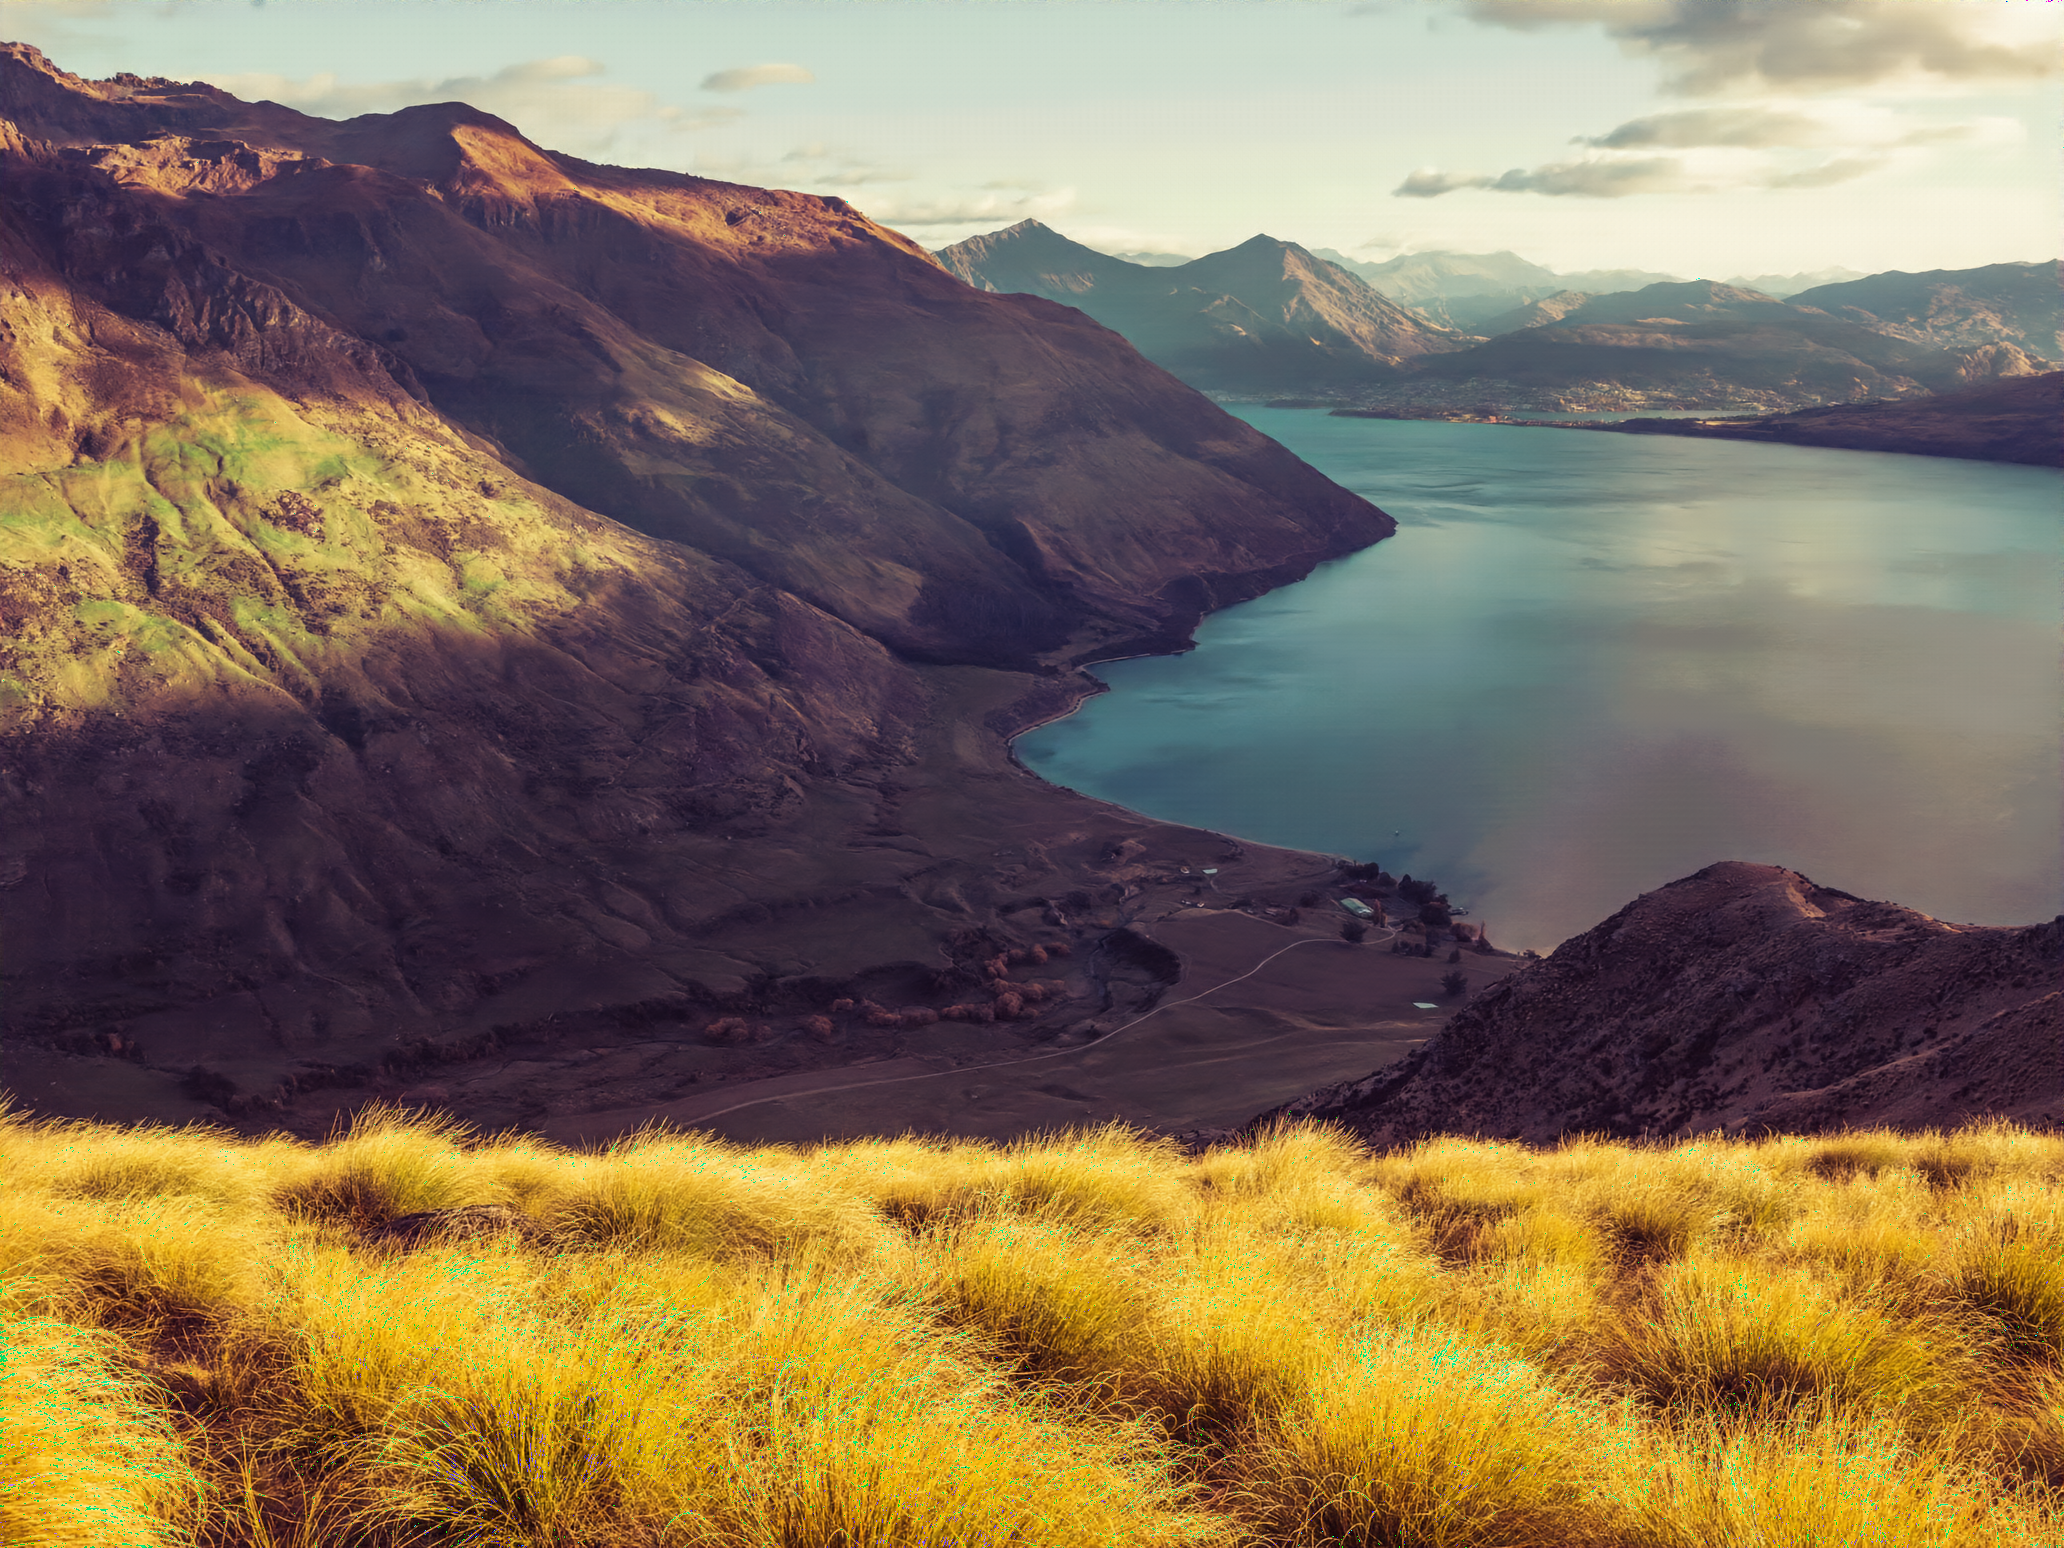

In [5]:
print(psnr)
ToPILImage()(x_hat[0] + 0.5)